In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import math
import seaborn as sns
from scipy import signal
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm, Normalize
import random
from queue import Queue

In [2]:
def moment(img, order_p, order_q, fg_val):
    Mpq = 0.0
    (height, width) = img.shape
    for h in range(height):
        for w in range(width):
            if(img[h,w]==fg_val):
                Mpq += ((w**order_p)*(h**order_q))
    return Mpq

In [3]:
def central_moment(img, order_p, order_q, fg_val):
    m_00 = moment(img, 0, 0, fg_val)
    x_ctr = moment(img, 1, 0, fg_val) / m_00
    y_ctr = moment(img, 0, 1, fg_val) / m_00
    (height, width) = img.shape
    cMpq = 0.0
    for h in range(height):
        for w in range(width):
            if(img[h,w]==fg_val):
                cMpq += ((w-x_ctr)**order_p)*((h-y_ctr)**order_q)
    return cMpq

In [4]:
def normalized_central_moment(img, order_p, order_q, fg_val):
    m_00 = moment(img, 0, 0, fg_val)
    norm = m_00 ** (0.5*(order_p+order_q+2))
    return central_moment(img, order_p, order_q, fg_val)/norm

In [5]:
def compute_degree(img, fg_value):
    cm_11 = central_moment(img, 1, 1, fg_value)
    cm_20 = central_moment(img, 2, 0, fg_value)
    cm_02 = central_moment(img, 0, 2, fg_value)
    img_rotate_rad = 0.5*math.atan2(2*cm_11, cm_20-cm_02)
    img_rotate_deg = math.degrees(img_rotate_rad)
    return img_rotate_rad, img_rotate_deg

In [6]:
bolt_img = plt.imread(r"D:\image_processing_practice\DIP_Java\imagingbook_images_de3\ch10\bolt-clean.tif")[:,:,0]

(224, 250)


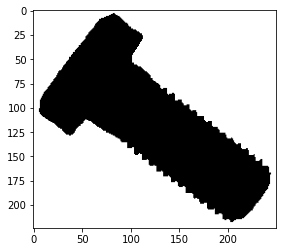

In [7]:
print(bolt_img.shape)
plt.imshow(bolt_img, cmap="gray")
plt.show()

In [8]:
bolt_img_rotate_radian, bolt_img_rotate_degree = compute_degree(bolt_img, 0)
print(bolt_img_rotate_degree)

37.404351266820434


In [9]:
rect_img = plt.imread(r"D:\image_processing_practice\DIP_Java\imagingbook_images_de3\ch10\roundness-2-200.tif")[:,:,0]

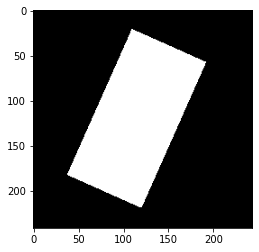

In [10]:
plt.imshow(rect_img, cmap="gray")
plt.show()

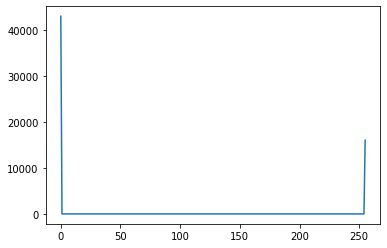

In [11]:
hist_rect = cv2.calcHist([rect_img], [0], None, [256], [0, 256])
plt.plot(hist_rect)
plt.show()

In [12]:
rect_img_rotate_radian, rect_img_rotate_degree = compute_degree(rect_img, 255)
print(rect_img_rotate_degree)

-66.10588766214663


![ch10_mmbased_geoprop](../assets/ch10_mmbased_geoprop.png)

In [37]:
# eigenvalue is an important component for creating ellipse shape
# highest eigenvalue must be used for computing r_a
def ellipse_axes(img, fg_val):
    m_00 = moment(img, 0, 0, fg_val)
    cm_11 = central_moment(img, 1, 1, fg_val)
    cm_20 = central_moment(img, 2, 0, fg_val)
    cm_02 = central_moment(img, 0, 2, fg_val)
    A = np.array([[cm_20, cm_11],[cm_11, cm_02]])
    w = np.linalg.eigvals(A)
    print(w)
    r_a = 2*np.sqrt(max(w)/m_00)
    r_b = 2*np.sqrt(min(w)/m_00)
    return r_a, r_b

In [38]:
def ellipse_parametric_eq(img, t, angle_rad, r_a, r_b, fg_value):
    m_10 = moment(img, 1, 0, fg_value)
    m_01 = moment(img, 0, 1, fg_value)
    m_00 = moment(img, 0, 0, fg_value)
    x_bar = m_10/m_00
    y_bar = m_01/m_00
    x_pos = x_bar + (np.cos(angle_rad)*r_a*np.cos(t)) - (np.sin(angle_rad)*r_b*np.sin(t))
    y_pos = y_bar + (np.sin(angle_rad)*r_a*np.cos(t)) + (np.cos(angle_rad)*r_b*np.sin(t))
    return x_bar, y_bar, x_pos, y_pos

In [39]:
r_bolt_a, r_bolt_b = ellipse_axes(bolt_img, 0)
print(r_bolt_a, r_bolt_b)

[1.03728388e+08 1.37638682e+07]
144.9166580049678 52.788551958844664


In [40]:
print(bolt_img_rotate_degree, bolt_img_rotate_radian)

37.404351266820434 0.6528290841785286


In [41]:
ang = np.linspace(0, 2*np.pi, 50)
x_li = []
y_li = []
for data in ang:
    _, _, x_el, y_el = ellipse_parametric_eq(bolt_img, data, bolt_img_rotate_radian, r_bolt_a, r_bolt_b, 0)
    x_li.append(x_el)
    y_li.append(y_el)

In [42]:
x_bar_el, y_bar_el, x_el, y_el = ellipse_parametric_eq(bolt_img, 0, bolt_img_rotate_radian, r_bolt_a, r_bolt_b, 0)

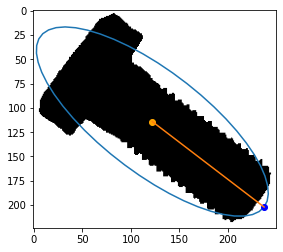

In [43]:
plt.plot(x_li, y_li)
plt.imshow(bolt_img, cmap="gray")
plt.plot(x_bar_el, y_bar_el, marker="o", color="orange")
plt.plot(x_el, y_el, marker="o", color="blue")
plt.plot([x_bar_el, x_el], [y_bar_el, y_el])

In [44]:
r_rect_a, r_rect_b = ellipse_axes(rect_img, 255)
print(r_rect_a, r_rect_b)

[10926231.42144163 42001117.31424497]
102.36216854760349 52.20886518066706


In [45]:
print(rect_img_rotate_degree, rect_img_rotate_radian)

-66.10588766214663 -1.1537653946579556


In [46]:
ang = np.linspace(0, 2*np.pi, 50)
x_li = []
y_li = []
for data in ang:
    _, _, x_el, y_el = ellipse_parametric_eq(rect_img, data, rect_img_rotate_radian, r_rect_a, r_rect_b, 255)
    x_li.append(x_el)
    y_li.append(y_el)

In [47]:
x_bar_el, y_bar_el, x_el, y_el = ellipse_parametric_eq(rect_img, 0, rect_img_rotate_radian, r_rect_a, r_rect_b, 255)

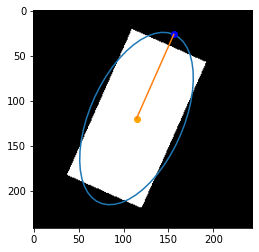

In [48]:
plt.plot(x_li, y_li)
plt.imshow(rect_img, cmap="gray")
plt.plot(x_bar_el, y_bar_el, marker="o", color="orange")
plt.plot(x_el, y_el, marker="o", color="blue")
plt.plot([x_bar_el, x_el], [y_bar_el, y_el])

In [49]:
leaf_img = plt.imread(r"D:\image_processing_practice\DIP_Java\imagingbook_images_de3\ch10\pliers.jpg")[:,:,0]

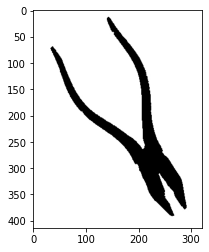

In [50]:
plt.imshow(leaf_img, cmap="gray")

In [51]:
np.unique(leaf_img)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8, 247, 248, 249, 250,
       251, 252, 253, 254, 255], dtype=uint8)

In [52]:
leaf_angle_rad, leaf_angle_deg = compute_degree(leaf_img, 0)
print(leaf_angle_deg)

61.184383729509186


In [53]:
r_leaf_a, r_leaf_b = ellipse_axes(leaf_img, 0)

[1.78781430e+07 1.11503137e+08]


In [54]:
x_bar_el, y_bar_el, x_el, y_el = ellipse_parametric_eq(leaf_img, 0, leaf_angle_rad, r_leaf_a, r_leaf_b, 0)

In [55]:
ang = np.linspace(0, 2*np.pi, 50)
x_li = []
y_li = []
for data in ang:
    _, _, x_el, y_el = ellipse_parametric_eq(leaf_img, data, leaf_angle_rad, r_leaf_a, r_leaf_b, 0)
    x_li.append(x_el)
    y_li.append(y_el)

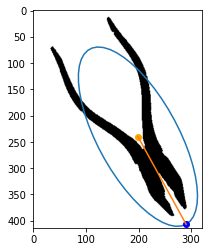

In [56]:
plt.plot(x_li, y_li)
plt.imshow(leaf_img, cmap="gray")
plt.plot(x_bar_el, y_bar_el, marker="o", color="orange")
plt.plot(x_el, y_el, marker="o", color="blue")
plt.plot([x_bar_el, x_el], [y_bar_el, y_el])